# Evaluation of XGBoost learning rates on distribution of 10k thrombolysis rates

As hospital ID is encoded as one-hot, and there are 132 hospitals, it is possible that the effect of hospitals ID becomes 'regularised out'. Learning rate in XGBoost acts as a regulariser. The lower the learning rate the less weight new trees have, and so the model becomes more regularised (less likely to overfit). 

Here we optimise the learning rate to maximise accuracy while maintaining the f=effect of hospital ID.

A learning rate of 0.5 is selected.

In [1]:
## Import libraries

In [2]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data and restrict to key features

In [4]:
data_loc = '../data/10k_training_test/'

train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')

train = train[key_features]
test = test[key_features]

## Combined XGBoost Model

In [5]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

learning_rates = [0.1, 0.25, 0.5, 0.75, 1.0]
thrombolysis_rates_by_lr = dict()

for lr in learning_rates:

    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=lr)

    # Fit model
    model.fit(X_train, y_train)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Learning rate: {lr}. Accuracy: {accuracy:0.3f}')
    
    # Pass 10k cohort through all hospital models and get thrombolysis rate
    hospitals = list(set(train['StrokeTeam']))
    hospitals.sort()
    thrombolysis_rate = []
    single_predictions = []

    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get predicted probabilities and class
        y_probs = model.predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
    
    # Stote thrombolysis rates
    thrombolysis_rates_by_lr[lr] = thrombolysis_rate   

Learning rate: 0.1. Accuracy: 0.843
Learning rate: 0.25. Accuracy: 0.849
Learning rate: 0.5. Accuracy: 0.848
Learning rate: 0.75. Accuracy: 0.843
Learning rate: 1.0. Accuracy: 0.835


## Plot histograms of 10k thrombolysis rates, depending on XGBoost learning rate

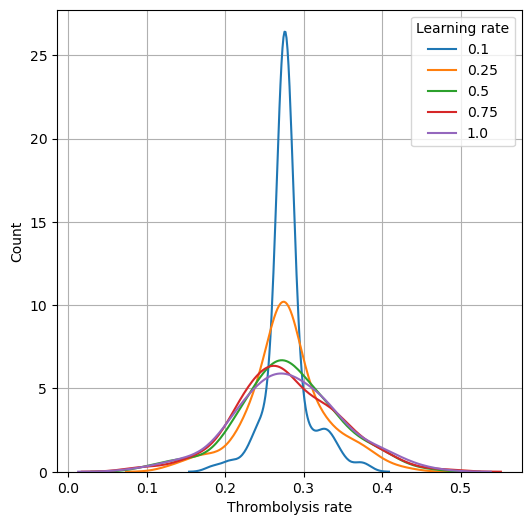

In [6]:
# Set up chart
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
for k, v in thrombolysis_rates_by_lr.items():
    sns.distplot(v, label=k, hist=False, ax=ax)
ax.legend(title='Learning rate')
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
ax.grid()
plt.savefig('./output/91_learning_rate.jpg', dpi=300)
plt.show()

## Show key data for 10k thrombolysis rates, depending on XGBoost learning rate

In [7]:
results = dict()
for k, v in thrombolysis_rates_by_lr.items():
    mean = np.mean(v)
    stdev = np.std(v)
    minimum = np.min(v)
    maximum = np.max(v)
    results[k] = [mean, stdev, minimum, maximum]
    
results = pd.DataFrame(results, 
                       index=['Mean', 'StdDev', 'Min', 'Max'])

results

,0.10,0.25,0.50,0.75,1.00
Mean,0.279060,0.278257,0.279636,0.278680,0.280369
StdDev,0.026747,0.050928,0.063063,0.065618,0.067114
Min,0.184300,0.131300,0.101000,0.091700,0.088800
Max,0.378400,0.429000,0.452700,0.476900,0.462300


## Observations

* Learning rates of less than 0.5 reduce the effect of hospital ID on 10k thrombolysis rates; the predicted thrombolysis rates are pulled closer to the mean thrombolysis rate.
* Standard deviation of 10k thrombolysis rate increases with learning rate, but is near-maximal at learning rate of 0.5
* Test set accuracy drops a little above learning rates of 0.25, but the effect is minimal at learning rate 0.5 (accuracy of 84.1% vs 84.5% at learning rate of 0.25 and below).
* A learning rate of 0.5 is selected to balance accuracy and maintaining the effect of hospital ID on thrombolysis rate.